In [107]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
import pandas as pd
# StringIO from pd.compat
import io
import matplotlib.pyplot as plt

In [181]:
global df, dfO
dfO = pd.DataFrame(columns=["Time", "Res_Freq", "Amplitude", "Phase", "Sample_number"])

In [234]:
def reload_data(debug=False):
    #deep copy of dfO
    df = dfO.copy(deep=True)
    # for each sample in data_/Snail/<folder>/<name>.txt open the txt file and append the data to a pandas dataframe
    file_loaded = 0

    for root, dirs, files in os.walk("../data_/Snail"):
        for name in files:
            if name.endswith(".txt"):
                file_path = os.path.join(root, name)
                sample_number = root.split("_")[-1]
                with open(file_path, "r") as f:
                    lines = f.readlines()
                
                file_loaded += 1

                header_index = lines.index("X_Value\tTime\tRes.Frequency\tAmplitude\tPhase\tComment\n")
                data_rows = lines[header_index+1:]

                data_values = [line.strip().split('\t')[:] for line in data_rows]
                #add the sample number to the data_values :
                # from [['0.050003', '1448.050731', '27.196000', '-5.780000'], ['0.150009', '1448.060841', '27.192000', '-5.720000'],..]
                # to [['0.050003', '1448.050731', '27.196000', '-5.780000', sample_number], ['0.150009', '1448.060841', '27.192000', '-5.720000', sample_number],..]
                data_values = [row + [sample_number] for row in data_values]
                
                
                df_new = pd.DataFrame(data_values, columns=["Time", "Res_Freq", "Amplitude", "Phase", "Sample_number"])

            

                df = pd.concat([df, df_new], ignore_index=True)


    df.astype({"Time": float, "Res_Freq": float, "Amplitude": float, "Phase": float, "Sample_number": int})
    df = df.apply(pd.to_numeric, errors='coerce')

    if debug:
        print("Files loaded: ", file_loaded)
        print("df shape: ", df.shape)
        # print("df head:\n",df.head())
    return df

df = reload_data(debug:=False)


In [278]:
def drop_outliers(debug=False, options:dict=None):
    df = reload_data(debug)

    options_default = {"Res_Freq_min": 1000, "Res_Freq_max": 5000,
                "Amplitude_min": None, "Amplitude_max": 40,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1350, 1600], "downsampling_rate" : 0.02}
    
    if options is not None:
        if debug: print("options received:" , options)
        for key in options_default.keys():
            if key in options.keys():
                options_default[key] = options[key]
        options = options_default
    else:
        options = options_default


    df = df.dropna()
    if debug: print("dfs-> dropna: ", df.shape)

    #drop duplicates
    df = df.drop_duplicates()
    if debug: print("dfs-> drop_duplicates: ", df.shape)


    #drop nan  in Res_Freq
    df = df[df.Res_Freq.notnull()]
    if debug: print(f"dfs-> dropna in Res_Freq: {df.shape}")

    

    # drop outliers in Res_Freq

    if options["Res_Freq_min"] is not None:
        df = df[df.Res_Freq > options["Res_Freq_min"]]
    if options["Res_Freq_max"] is not None:
        df = df[df.Res_Freq < options["Res_Freq_max"]]
        
    if debug: print(f"dfs-> outliers in Res_Freq [{options['Res_Freq_min']}:{options['Res_Freq_max']}] : {df.shape}")

    # drop outliers in Amplitude
    if options["Amplitude_min"] is not None:
        df = df[df.Amplitude > options["Amplitude_min"]]
    if options["Amplitude_max"] is not None:
        df = df[df.Amplitude < options["Amplitude_max"]]
    if debug: print(f"dfs-> outliers in Amplitude [{options['Amplitude_min']}:{options['Amplitude_max']}] : {df.shape}")

    # drop outliers in Phase
    if options["Phase_min"] is not None:
        df = df[df.Phase > options["Phase_min"]]
    if options["Phase_max"] is not None:
        df = df[df.Phase < options["Phase_max"]]
    if debug: print(f"dfs-> outliers in Phase [{options['Phase_min']}:{options['Phase_max']}] : {df.shape}")


    # reduce the number of data points in the interval [1350, 1600] of Res_Freq
    start = options["interval_df"][0]
    end = options["interval_df"][1]

    # Filter the dataframe to include values within the specified interval
    interval_df = df[(df['Res_Freq'] >= start) & (df['Res_Freq'] <= end)]

    downsampling_rate = options["downsampling_rate"]
    downsampled_df = interval_df.sample(frac=downsampling_rate, random_state=1)

    df = pd.concat([df[~((df['Res_Freq'] >= start) & (df['Res_Freq'] <= end))], downsampled_df])

    if debug: print(f"dfs-> downsampling at {downsampling_rate*100}% in [{start}: {end}]: {df.shape}")
        

    #print max value of Res_Freq for each sample
    #print("max Res_Freq for each sample:\n", df.groupby("Sample_number")["Res_Freq"].max())
    return df

df = drop_outliers(debug:=False, options:=None)

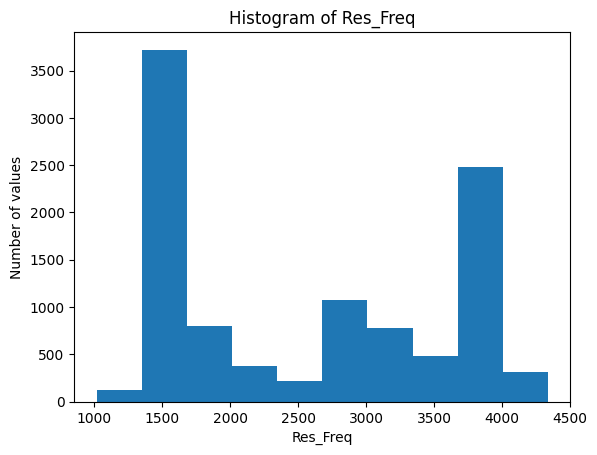

In [233]:
def plot_data_repartition(debug=False, options_outliers:dict=None):
    df = drop_outliers(debug, options_outliers)
    
    plt.hist(df["Res_Freq"], bins=10)  # Adjust the number of bins as needed

    # Set labels for x-axis and y-axis
    plt.xlabel("Res_Freq")
    plt.ylabel("Number of values")

    # Set a title for the plot
    plt.title("Histogram of Res_Freq")

    # Display the plot
    plt.show()


plot_data_repartition()

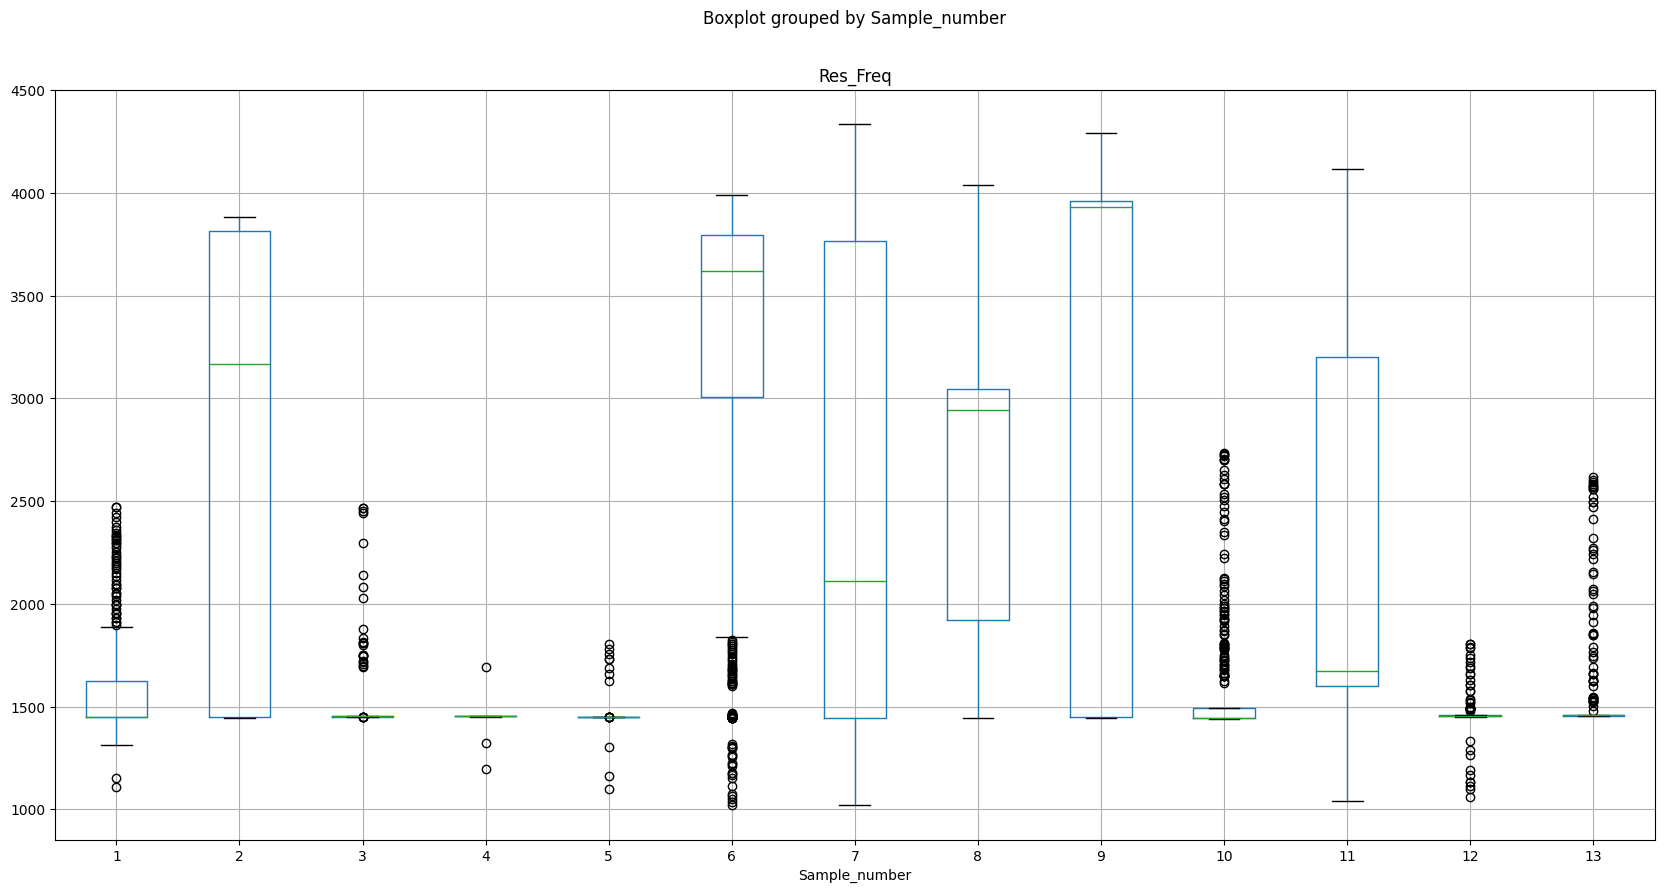

In [236]:
def plot_boxplot(column_to_plot:list, debug=False, options_outliers:dict=None):
    df = drop_outliers(debug, options_outliers)
    df.boxplot(column=column_to_plot, by="Sample_number", figsize=(20,10))

plot_boxplot(["Res_Freq"])

Files loaded:  13
df shape:  (176798, 5)
options received: {'Res_Freq_min': None, 'Res_Freq_max': None, 'Amplitude_max': None, 'downsampling_rate': 0.1}
dfs-> dropna:  (165998, 5)
dfs-> drop_duplicates:  (165998, 5)
dfs-> dropna in Res_Freq: (165998, 5)
dfs-> outliers in Res_Freq [None:None] : (165998, 5)
dfs-> outliers in Amplitude [None:None] : (165998, 5)
dfs-> outliers in Phase [None:None] : (165998, 5)
dfs-> downsampling at 10.0% in [1350: 1600]: (23099, 5)


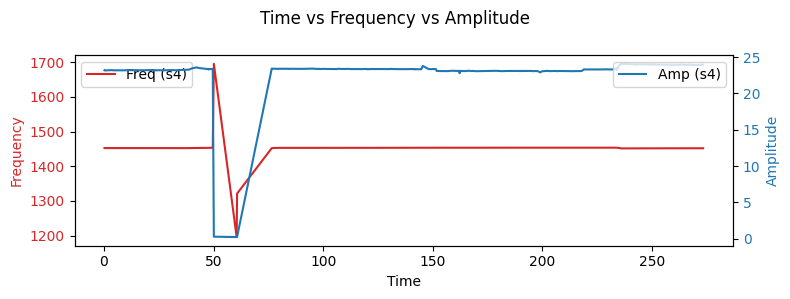

In [279]:
#df.plot.scatter(x="Time", y="Res_Freq", c="Sample_number", colormap="viridis")
# plot only for one sample
#df[df["Sample_number"] == 1].plot.scatter(x="Time", y="Res_Freq")

def plot_time_vs_Res_Freq_vs_Amplitude(sample_numbers, debug=False, options_outliers: dict = None):
    num_samples = len(sample_numbers)
    fig, axs = plt.subplots(num_samples, 1, figsize=(8, 3*num_samples))  # Adjust the figsize parameter for smaller size

    for i, sample_number in enumerate(sample_numbers):
        # Drop outliers and filter the dataframe based on the sample_number
        df = drop_outliers(debug, options_outliers)
        df = df[df["Sample_number"] == sample_number]

        # Extract the relevant columns
        time = df["Time"]
        res_freq = df["Res_Freq"]
        amplitude = df["Amplitude"]

        # Sort the values of time
        time, res_freq, amplitude = zip(*sorted(zip(time, res_freq, amplitude)))

        # Plot the lines on separate subplots
        ax = axs[i] if num_samples > 1 else axs  # Use the respective subplot
        color1 = 'tab:red'
        ax.plot(time, res_freq, color=color1, label="Freq (s{})".format(sample_number))
        ax.set_xlabel("Time")
        ax.set_ylabel("Frequency", color=color1)
        ax.tick_params(axis='y', labelcolor=color1)
        ax.legend(loc="upper left")

        ax2 = ax.twinx()  # Create a separate y-axis for amplitude
        color2 = 'tab:blue'
        ax2.plot(time, amplitude, color=color2, label="Amp (s{})".format(sample_number))
        ax2.set_ylabel("Amplitude", color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.legend(loc="upper right")

    # Set a common title for the plot
    fig.suptitle("Time vs Frequency vs Amplitude")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    

#plot_time_vs_Res_Freq_vs_Amplitude([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
plot_time_vs_Res_Freq_vs_Amplitude([4], debug=True, options_outliers={"Res_Freq_min": None, "Res_Freq_max": None, "Amplitude_max": None, "downsampling_rate": 0.1})


